Three approaches:

**1. Data Analytics Approach**

- Pros: Simple to implement, very efficient
- Cons: More difficult to make use of many variables which may be necessary to be accurate, linear divisions of metric-space only

**2. Machine learning (with variations in features used and models)**

- Pros: Efficient, can make use of all features, finds linear and nonlinear contributions from features,
- Cons: May require lots of data, may overfit if you are not careful, may not generalize to new domains

**3. Bottom-up Data Analytics Approach**
- Pros: No labels required! 
- Cons: Very computationally expensive without further improvements O(n!), same issues with data analytics approach with using extra features, still need test set to validate assumptions

In [299]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from scipy.stats import hmean
from nltk.corpus import stopwords
import string
import os
import joblib
import numpy as np

from IPython.display import display

%matplotlib inline

# Data Exploration

In [272]:
TRAIN_SIZE = .8

airbnb_property_info = pd.read_csv("property_matching_takehome/airbnb_property_info.csv")
airbnb_property_info["description"].fillna("",inplace=True)
homeaway_property_info = pd.read_csv("property_matching_takehome/homeaway_property_info.csv")
labels = pd.read_csv("property_matching_takehome/labels.csv")

print("Airbnb size: {}, Homeaway size: {}, Labels size: {} \n".format(len(airbnb_property_info),len(homeaway_property_info), len(labels)))

print("Airbnb Info Columns: \n")
print(airbnb_property_info.columns.values)
print("\n")
print("Homeaway Info Columns: \n")
print(homeaway_property_info.columns.values)
print("\n")
print("Labels Columns: \n")
print(labels.columns.values)
print("\n")
columns_overlap = set(airbnb_property_info.columns.values).intersection(set(homeaway_property_info.columns.values))

print("Columns overlap: \n")
print(columns_overlap)

airbnb_property_info.head()

Airbnb size: 1995, Homeaway size: 1971, Labels size: 2038 

Airbnb Info Columns: 

['id' 'airbnb_property_id' 'airbnb_host_id' 'latitude' 'longitude'
 'description' 'title' 'property_type' 'neighborhood' 'img_cover'
 'address' 'views_day' 'views_week' 'views_month' 'img_count'
 'last_review_month' 'reviews_count' 'instant_book' 'response_rate'
 'wishlist_count' 'response_time_old' 'room_type' 'bed_type'
 'accommodates' 'bedrooms' 'extra_person_charge' 'bathrooms' 'check_in'
 'check_out' 'cancellation' 'security_deposit' 'minimum_stay'
 'cleaning_fee' 'price_weekly' 'price_monthly' 'price_nightly' 'guidebook'
 'smoking' 'pets_allowed' 'tv' 'internet' 'cabletv' 'wireless' 'aircon'
 'heating' 'elevator' 'pool' 'handicap_access' 'kitchen' 'doorman'
 'free_parking' 'gym' 'hottub' 'indoor_fireplace' 'intercom' 'breakfast'
 'suitable_for_events' 'family_friendly' 'washer' 'dryer' 'rating_overall'
 'rating_communication' 'rating_accuracy' 'rating_cleanliness'
 'rating_checkin' 'rating_location

,id,airbnb_property_id,airbnb_host_id,latitude,longitude,description,title,property_type,neighborhood,img_cover,...,c_revenue_potential_ltm,score,desc_license,amenities,currency_native,display_exact_location,property_plus,location_title,home_collection,response_time_text
0,4306334,25910,96951,15.857221,-97.069411,Casa Azul is for Adults only. Our home Casa A...,Escape From the Ordinary- Beautiful Palapa Home,House,NaN,https://a0.muscache.com/im/pictures/aaa41a30-3...,...,NaN,49.42860,NaN,"['kitchen', 'wireless_internet', 'laptop-frien...",USD,NaN,NaN,"Puerto Escondido, OAX, Mexico",NaN,within a day
1,4397831,52834,244930,34.041607,-4.999191,Very Important: The property is located in a r...,Luxury Riad Saad,Apartment,NaN,https://a0.muscache.com/im/pictures/305876/be2...,...,NaN,7.42857,NaN,"['free_parking', 'kitchen', 'hangers', 'cable'...",EUR,NaN,NaN,"Fes, Fes-Boulemane, Morocco",NaN,NaN
2,3850509,53131,246897,20.630224,-87.068474,We speak english / hablamos espanol / parliamo...,Central Two-Story Penthouse on 1st Avenue,Apartment,NaN,https://a0.muscache.com/im/pictures/0f004084-3...,...,NaN,62.00000,NaN,"['ac', 'essentials', 'laptop-friendly', 'tv', ...",USD,NaN,NaN,"Playa del Carmen, Quintana Roo, Mexico",['For Families'],within a few hours
3,746735,71630,198809,43.508350,16.436531,Apartment in a house built at the half of the ...,Comfortable studio on the Riva waterfront,Apartment,Grad,https://a0.muscache.com/im/pictures/49a7864e-d...,...,NaN,64.00000,NaN,"['kitchen', 'wireless_internet', 'laptop-frien...",EUR,True,NaN,"Grad, Split, Split-Dalmatia, Croatia",NaN,within an hour
4,10348879,87685,480088,37.732709,-0.740103,An ideal location for sea lovers and with the ...,Family Beachside 3 bedroom Apartment La Manga,Apartment,NaN,https://a0.muscache.com/im/pictures/69f7a50b-8...,...,NaN,21.42860,NaN,"['ac', 'ethernet_connection', 'essentials', 'h...",GBP,NaN,NaN,"San Javier, Region of Murcia, Spain",NaN,within a few hours


In [273]:
airbnb_property_info = airbnb_property_info[list(columns_overlap)]
airbnb_property_info.describe()

,c_days_b_ltm,id,cleaning_fee_native,longitude,score,latitude,response_rate,accommodates,c_num_res_ltm,c_revenue_native_ltm,...,c_revenue_potential_ltm,security_deposit,img_count,c_adr_native_ltm,c_adr_ltm,country_id,response_time,c_days_r_ltm,bathrooms,c_revenue_ltm
count,1819.000000,1.995000e+03,1700.000000,1995.000000,1922.000000,1995.000000,1943.000000,1995.000000,1995.000000,1.995000e+03,...,561.000000,1629.000000,1995.000000,1819.000000,1819.000000,1995.000000,1733.000000,1819.000000,1995.000000,1995.000000
mean,24.144585,6.572797e+06,315.465294,-23.525509,37.665077,33.139277,95.903242,5.262155,27.234085,1.145744e+05,...,39235.863904,214.653775,23.691228,1580.255717,200.971117,27.463158,8569.367282,106.128092,1.618296,18180.214035
std,27.038263,3.210294e+06,4894.762742,63.662478,20.677742,18.538609,14.347027,2.749660,26.816922,1.924177e+06,...,26328.125911,385.183819,15.332487,24873.250321,211.287809,38.757728,14920.067423,76.947016,0.994615,23292.640403
min,0.000000,8.014000e+03,0.000000,-159.512886,0.000000,-45.883722,0.000000,1.000000,0.000000,0.000000e+00,...,0.000000,0.000000,1.000000,11.545500,11.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,3.000000,4.355124e+06,0.000000,-81.451179,21.285700,28.425067,100.000000,4.000000,6.000000,3.746375e+03,...,21482.900000,0.000000,14.000000,81.484650,86.949600,1.000000,175.000000,46.000000,1.000000,3738.500000
50%,15.000000,7.338849e+06,45.000000,-0.669055,28.571400,38.041118,100.000000,4.000000,21.000000,1.021820e+04,...,34975.700000,114.000000,21.000000,147.141000,146.551000,4.000000,5323.000000,95.000000,1.000000,10443.000000
75%,35.000000,9.132863e+06,100.000000,12.343246,56.392875,43.536873,100.000000,6.000000,39.000000,2.544410e+04,...,49062.300000,286.000000,29.000000,249.838000,236.124500,54.500000,7730.000000,140.000000,2.000000,24189.500000
max,159.000000,1.165761e+07,150000.000000,176.241264,96.285700,64.141753,100.000000,16.000000,210.000000,7.314630e+07,...,194688.000000,5000.000000,175.000000,828672.000000,2610.120000,286.000000,86400.000000,360.000000,12.500000,247604.000000


In [274]:
homeaway_property_info = homeaway_property_info[list(columns_overlap)]
homeaway_property_info.describe()

,c_days_b_ltm,id,cleaning_fee_native,longitude,currency_native,score,latitude,response_rate,accommodates,c_num_res_ltm,...,c_revenue_potential_ltm,security_deposit,img_count,c_adr_native_ltm,c_adr_ltm,country_id,response_time,c_days_r_ltm,bathrooms,c_revenue_ltm
count,1805.000000,1.971000e+03,0.0,1971.000000,0.0,0.0,1971.000000,718.000000,1971.000000,1971.000000,...,0.0,340.000000,1971.000000,0.0,1793.000000,1971.000000,1556.000000,1805.000000,1944.000000,1971.000000
mean,14.384488,1.748506e+06,NaN,-24.032744,NaN,NaN,33.007948,90.766017,5.670726,9.183663,...,NaN,391.752941,22.949264,NaN,218.896092,27.068493,45.608612,147.555679,1.613426,29670.646880
std,21.362347,7.159324e+05,NaN,63.816667,NaN,NaN,18.613958,19.006814,4.882336,9.852813,...,NaN,499.932430,11.195560,NaN,242.927083,38.653319,84.572344,89.203303,0.997227,46666.240856
min,0.000000,1.994000e+03,NaN,-159.511993,NaN,NaN,-45.884730,0.000000,0.000000,0.000000,...,NaN,23.000000,5.000000,NaN,6.627740,1.000000,1.000000,1.000000,0.500000,0.000000
25%,3.000000,1.293330e+06,NaN,-81.451749,NaN,NaN,28.424642,90.000000,4.000000,0.000000,...,NaN,171.000000,15.000000,NaN,96.732800,1.000000,1.000000,71.000000,1.000000,5872.000000
50%,7.000000,1.970483e+06,NaN,-1.170343,NaN,NaN,38.035735,100.000000,5.000000,6.000000,...,NaN,254.000000,22.000000,NaN,159.730000,4.000000,24.000000,146.000000,1.000000,17501.000000
75%,14.000000,2.271351e+06,NaN,12.475252,NaN,NaN,43.535685,100.000000,7.000000,16.000000,...,NaN,500.000000,28.000000,NaN,256.466000,53.000000,48.000000,216.000000,2.000000,35485.500000
max,184.000000,2.768706e+06,NaN,176.240950,NaN,NaN,64.144699,100.000000,99.000000,57.000000,...,NaN,5000.000000,50.000000,NaN,2872.340000,286.000000,348.000000,365.000000,12.500000,644373.000000


In [275]:
labels["target"].value_counts()

1.0    1019
0.0    1019
Name: target, dtype: int64

In [276]:
# airbnb_property_info["cleaning_fee_native"].describe()
# airbnb_property_info["property_type"].value_counts(dropna=False)
# airbnb_property_info["rating_overall"].value_counts(dropna=False)
# airbnb_property_info["pets_allowed"].value_counts()
airbnb_property_info["security_deposit"].value_counts(dropna=False)

 0.0       717
NaN        366
 500.0      78
 100.0      48
 228.0      47
 114.0      42
 300.0      42
 250.0      35
 342.0      33
 171.0      30
 200.0      28
 229.0      24
 227.0      20
 113.0      18
 285.0      17
 172.0      15
 343.0      14
 570.0      13
 150.0      13
 115.0      13
 275.0      12
 341.0      12
 1000.0     12
 286.0      10
 1500.0      9
 226.0       8
 127.0       7
 572.0       7
 70.0        6
 141.0       6
          ... 
 225.0       1
 1275.0      1
 705.0       1
 571.0       1
 627.0       1
 1709.0      1
 303.0       1
 666.0       1
 317.0       1
 2264.0      1
 197.0       1
 347.0       1
 674.0       1
 139.0       1
 375.0       1
 1160.0      1
 175.0       1
 1140.0      1
 294.0       1
 201.0       1
 1144.0      1
 245.0       1
 199.0       1
 1466.0      1
 2861.0      1
 459.0       1
 2988.0      1
 1710.0      1
 449.0       1
 795.0       1
Name: security_deposit, Length: 215, dtype: int64

# Preprocessing

In [277]:
# Split into train and test. We could do even class splits but just shuffling should work fine
labels = labels.sample(frac=1).reset_index(drop=True)
num_train_labels = int(len(labels) * TRAIN_SIZE)
labels_train = labels[:num_train_labels]
labels_test = labels[num_train_labels:]

print("Train size: {}, Test size: {}".format(len(train_labels), len(test_labels)))

assert len(labels) == len(train_labels) + len(test_labels)

labels_train.to_csv("property_matching_takehome/labels_train.csv",index=False)
labels_test.to_csv("property_matching_takehome/labels_test.csv",index=False)

Train size: 1528, Test size: 510


# Data Analytics Approach

Calculate Euclidean Distance between two locations in listings. Calculate cosine similarity between property description TF-IDF vectors. Then determine best threshold for these features to determine if they are the same or not.

In [363]:
def text_process(mess): # This function was taken from a tutorial online
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

def get_bow_transformer(airbnb_property_info, homeaway_property_info, column="description", relearn=False):
    if os.path.isfile("models/bow_" + column + "_vectorizer.pkl") and not relearn:
        print("Bag of Words Vectorizer already trained. Loading...")
        bow_transformer = joblib.load("models/bow_description_vectorizer.pkl")
        
    else:
        print("Learning bag of words vectorizer")
        bow_transformer = TfidfVectorizer(analyzer=text_process)
        bow_transformer.fit(airbnb_property_info[column].dropna())
        bow_transformer.fit(homeaway_property_info[column].dropna())
        
        joblib.dump(bow_transformer, "models/bow_" + column + "_vectorizer.pkl")
    
    return bow_transformer

def euclidean_distance(row):# Euclidean distance is a decent approximation for short distances. No need to use Haversine.
    x1 = row["latitude_x"]
    y1 = row["longitude_x"]
    x2 = row["latitude_y"]
    y2 = row["longitude_y"]
    return ((x2-x1) ** 2 + (y2-y1) ** 2) ** (1/2)

# Could use z-score instead but this would not be conveniently between 0 and 1
def normalize_euclidean(distance, mean, std):
#     normalized = (distance - min_distance) / (max_distance - min_distance)
    normalized = (distance - mean) / std
    return normalized

In [364]:
def combine_and_compare_features_data_analytics(labels, airbnb_property_info, homeaway_property_info, relearn_bow=False, verbose=False):
    labels = labels.copy(deep=True) # Make a copy so that we aren't manipulating outside object
    # Slice only columns that we need
    airbnb_property_info = airbnb_property_info[["airbnb_property_id", "latitude","longitude","description"]]
    homeaway_property_info = homeaway_property_info[["homeaway_property_id", "latitude","longitude","description"]]

    # Merge data
    labels = labels.merge(airbnb_property_info, on="airbnb_property_id")
    labels = labels.merge(homeaway_property_info, on="homeaway_property_id")

    bow_transformer = get_bow_transformer(airbnb_property_info, homeaway_property_info, column="description", relearn=relearn_bow)
    print("Now applying bow vectorizer to extract vectors...")

    labels["description_x"].fillna("",inplace=True)
    labels["description_y"].fillna("",inplace=True)

    labels["description_vector_x"] = labels["description_x"].apply(lambda x: bow_transformer.transform([x]))
    labels["description_vector_y"] = labels["description_y"].apply(lambda x: bow_transformer.transform([x]))
#     labels["description_vector_x"] = labels["title_x"].apply(lambda x: bow_transformer.transform([x]))
#     labels["description_vector_y"] = labels["title_y"].apply(lambda x: bow_transformer.transform([x]))

    labels["cosine_similarity"] = labels.apply(lambda row: cosine_similarity(row["description_vector_x"], row["description_vector_y"])[0], axis=1)['description_vector_x']
    labels["cosine_similarity"].fillna(0, inplace=True)
    if verbose:
        plt.title("Distribution of Cosine Similarity Between Descriptions")
        plt.hist(labels["cosine_similarity"])
        plt.show()
    
    labels["euclidean_distance"] = labels.apply(lambda row: euclidean_distance(row), axis=1)
    min_distance = labels["euclidean_distance"].min()
    max_distance = labels["euclidean_distance"].max()

    distance_mean = labels_enhanced["euclidean_distance"].mean()
    distance_std = labels_enhanced["euclidean_distance"].std()

    labels["normalized_euclidean_distance"] = labels.apply(lambda row: normalize_euclidean(row["euclidean_distance"],distance_mean,distance_std), axis=1)
    labels["normalized_euclidean_distance"].fillna(0, inplace=True)
    
    if verbose:
        plt.title("Normalized Euclidean Distance between Listing Locations")
        plt.hist(labels["normalized_euclidean_distance"])
        plt.show()
    
    return labels


Bag of Words Vectorizer already trained. Loading...
Now applying bow vectorizer to extract vectors...


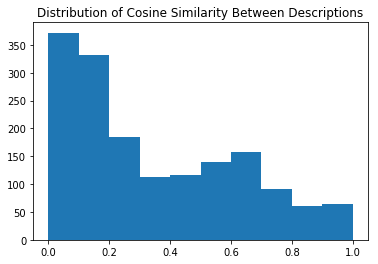

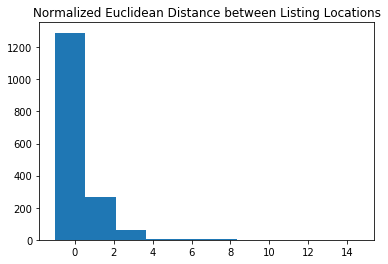

,airbnb_property_id,homeaway_property_id,target,latitude_x,longitude_x,description_x,latitude_y,longitude_y,description_y,description_vector_x,description_vector_y,cosine_similarity,euclidean_distance,normalized_euclidean_distance
0,21126169,4501868,0.0,28.359467,-81.540100,Closest to Disney Magic! Located in Lake Buena...,28.359931,-81.539042,"This world-class resort with spacious, luxurio...","(0, 29456)\t0.19192755414099008\n (0, 29365...","(0, 31260)\t0.3324512120058348\n (0, 30755)...",0.108855,0.001156,-0.610567
1,2473187,572958vb,0.0,22.071765,-159.318125,The Pono Kai Resort is located centrally on th...,22.072094,-159.317655,Enjoy a romantic sunrise and all the luxuries ...,"(0, 29397)\t0.13590395550961468\n (0, 25313...","(0, 30736)\t0.04467829009361018\n (0, 30591...",0.399778,0.000573,-0.829739
2,22084212,1672240a,0.0,40.738511,-73.997465,Lovely and spacious one bedroom in a charming ...,40.738087,-73.999379,Beautifully presented West Village 2 BR Duplex...,"(0, 29524)\t0.18996016255535858\n (0, 28638...","(0, 30525)\t0.16214014716054007\n (0, 30285...",0.137362,0.001961,-0.307687
3,17471131,8529248,0.0,41.389683,2.172625,"This apartment has: 1 double bed, 1 double sof...",41.389188,2.171538,Situated on one of the most beautiful streets ...,"(0, 28467)\t0.256513948127122\n (0, 28221)\...","(0, 30513)\t0.09861165527752723\n (0, 30319...",0.053127,0.001195,-0.595859
4,29547205,4808358,1.0,28.211198,-81.559799,277 Yellow Snapdragon Drive \n\nProperty Type:...,28.211861,-81.558774,277 Yellow Snapdragon Drive\t\t\t\t\t\t\t\nPro...,"(0, 28345)\t0.18533246924463817\n (0, 26191...","(0, 28345)\t0.1071920676666496\n (0, 28214)...",0.665000,0.001220,-0.586363


In [280]:
airbnb_property_info = pd.read_csv("property_matching_takehome/airbnb_property_info.csv")
homeaway_property_info = pd.read_csv("property_matching_takehome/homeaway_property_info.csv")
labels_train = pd.read_csv("property_matching_takehome/labels_train.csv")

labels_train_enhanced = combine_and_compare_features_data_analytics(labels_train, airbnb_property_info, homeaway_property_info, relearn_bow=False, verbose=True)
labels_train_enhanced.head()

In [281]:
def infer_threshold(euclidean_distance, cosine_similarity, distance_threshold, similarity_threshold):
    if euclidean_distance < distance_threshold and cosine_similarity > similarity_threshold:
        return 1
    else:
        return 0
    

def get_accuracy_metrics(confusion):
    if 1 in confusion[1]:
        tp = confusion[1][1]
    else:
        return 0, 0, 0
    
    if 0 in confusion[0]:
        tn = confusion[0][0]
    else:
        tn = 0
    
    if 0 in confusion[1]:
        fn = confusion[1][0]
    else:
        fn = 0
        
    if 1 in confusion[0]:
        fp = confusion[0][1]
    else:
        fp = 0

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = hmean([precision, recall])
    
    return precision, recall, f1
    
def make_prediction_data_analytics(data, distance_threshold, similarity_threshold, verbose=False, infer_func=infer_threshold):
    return data.apply(lambda row: infer_func(row["normalized_euclidean_distance"], row["cosine_similarity"], distance_threshold, similarity_threshold), axis=1)

def make_prediction_and_evaluate(data, distance_threshold, similarity_threshold, verbose=False, infer_func=infer_threshold):
    data["prediction"] = make_prediction_data_analytics(data, distance_threshold, similarity_threshold)

    confusion = data.groupby("target")["prediction"].value_counts()
    
    precision, recall, f1 = get_accuracy_metrics(confusion)

    if verbose:
        print("Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}".format(precision, recall, f1))
    
    return precision, recall, f1

def grid_search(data, grid_size=20, max_distance=2, min_similarity=.25):
    best_hyperparameters = {}
    best_hyperparameters["best_precision"] = {}
    best_hyperparameters["best_precision"]["precision"] = 0
    best_hyperparameters["best_recall"] = {}
    best_hyperparameters["best_recall"]["recall"] = 0
    best_hyperparameters["best_f1"] = {}
    best_hyperparameters["best_f1"]["f1"] = 0
    
    for similarity_threshold in np.linspace(min_similarity, 1, grid_size):
        for distance_threshold in np.linspace(data["normalized_euclidean_distance"].min(), max_distance, grid_size):
            precision, recall, f1 = make_prediction_and_evaluate(data, distance_threshold, similarity_threshold)
            
            if precision > best_hyperparameters["best_precision"]["precision"]:
                best_hyperparameters["best_precision"]["precision"] = precision
                best_hyperparameters["best_precision"]["similarity_threshold"] = similarity_threshold
                best_hyperparameters["best_precision"]["distance_threshold"] = distance_threshold
                
            if recall > best_hyperparameters["best_recall"]["recall"]:
                best_hyperparameters["best_recall"]["recall"] = recall
                best_hyperparameters["best_recall"]["similarity_threshold"] = similarity_threshold
                best_hyperparameters["best_recall"]["distance_threshold"] = distance_threshold
                
            if f1 > best_hyperparameters["best_f1"]["f1"]:
#                 print(f1, similarity_threshold, distance_threshold)
                best_hyperparameters["best_f1"]["f1"] = f1
                best_hyperparameters["best_f1"]["similarity_threshold"] = similarity_threshold
                best_hyperparameters["best_f1"]["distance_threshold"] = distance_threshold
                
    best_similarity_threshold = best_hyperparameters["best_f1"]["similarity_threshold"]
    best_distance_threshold = best_hyperparameters["best_f1"]["distance_threshold"]
    best_f1_achieved = best_hyperparameters["best_f1"]["f1"]
    
    print("Best F1 Achieved: {:.3f}, Best distance_threshold: {:.3f}, Best similarity_threshold: {:.3f}".format(best_f1_achieved, best_distance_threshold, best_similarity_threshold))
    return best_hyperparameters

best_hyperperameters = grid_search(labels_train_enhanced, grid_size=10, max_distance=2, min_similarity=0)

Best F1 Achieved: 0.843, Best distance_threshold: 2.000, Best similarity_threshold: 0.222


In [282]:
# Best Distance: 2.0
# Best Similarity: .22
best_hyperperameters["best_f1"]

{'distance_threshold': 2.0,
 'f1': 0.8431253785584494,
 'similarity_threshold': 0.2222222222222222}

In [283]:
labels_test = pd.read_csv("property_matching_takehome/labels_test.csv")
labels_test_enhanced = combine_and_compare_features_data_analytics(labels_test, airbnb_property_info, homeaway_property_info, relearn_bow=False)
make_prediction_and_evaluate(labels_test_enhanced, 2.0, .222222, verbose=True)

Bag of Words Vectorizer already trained. Loading...
Now applying bow vectorizer to extract vectors...
Precision: 0.757, Recall: 0.842, F1: 0.797


(0.7568807339449541, 0.8418367346938775, 0.7971014492753623)

# Machine learning approach
- Use ML algorithm (Logistic Regression, Random Forest, Support Vector Machine) to determine best combination of features to predict label
- Add more features in algorithmic fashion

In [284]:
# Logistic regression with few features
labels_train_enhanced_filtered = labels_train_enhanced[["airbnb_property_id", "homeaway_property_id", "target", "cosine_similarity", "normalized_euclidean_distance"]]

clf = LogisticRegression(random_state=42)
train_y = labels_train_enhanced_filtered[["target"]]
train_x = labels_train_enhanced_filtered.iloc[:,3:]

clf.fit(train_x,train_y)

predictions = clf.predict(train_x)

print("Training Classification accuracy: {:.3f}".format(accuracy_score(train_y, predictions)))
print(classification_report(train_y, predictions))

labels_test_enhanced_filtered = labels_test_enhanced[["airbnb_property_id", "homeaway_property_id", "target", "cosine_similarity", "normalized_euclidean_distance"]]

test_y = labels_test_enhanced_filtered[["target"]]
test_x = labels_test_enhanced_filtered.iloc[:,3:]

predictions = clf.predict(test_x)

print("Testing Classification accuracy: {:.3f}".format(accuracy_score(test_y, predictions)))
print(classification_report(test_y, predictions))

Training Classification accuracy: 0.853
             precision    recall  f1-score   support

        0.0       0.82      0.91      0.86       807
        1.0       0.90      0.80      0.85       823

avg / total       0.86      0.85      0.85      1630

Testing Classification accuracy: 0.821
             precision    recall  f1-score   support

        0.0       0.82      0.84      0.83       212
        1.0       0.83      0.80      0.81       196

avg / total       0.82      0.82      0.82       408



/home/daniel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [285]:
low_hanging_fruit_features = {
    "numeric": ["accommodates", "bathrooms", "bedrooms", "price_nightly", "score","cleaning_fee", "reviews_count", "security_deposit"],
    "nominal": ["property_type", "cancellation"],
    "binary": ["pets_allowed","instant_book"],
    "text": ["title", "description"]
}


In [356]:
def combine_and_compare_features_ml(labels, airbnb_property_info, homeaway_property_info, relearn_bow=False, merge=True):
    labels = labels.copy(deep=True) # Make a copy so that we aren't manipulating outside object

    if merge:
        columns_to_keep = ["latitude", "longitude"]

        for variable_type in low_hanging_fruit_features:
            columns_to_keep.extend(low_hanging_fruit_features[variable_type]) 

        columns_to_keep = list(set(columns_to_keep))

        airbnb_columns_to_keep = ["id", "airbnb_property_id"]
        airbnb_columns_to_keep.extend(columns_to_keep)

        airbnb_property_info = airbnb_property_info[airbnb_columns_to_keep]
        homeaway_columns_to_keep = ["id", "homeaway_property_id"]
        homeaway_columns_to_keep.extend(columns_to_keep)
        homeaway_property_info = homeaway_property_info[homeaway_columns_to_keep]

        labels = labels.merge(airbnb_property_info, on="airbnb_property_id")
        labels = labels.merge(homeaway_property_info, on="homeaway_property_id")

    print("Calculating distance")
    labels["euclidean_distance"] = labels.apply(lambda row: euclidean_distance(row), axis=1)
    distance_mean = labels["euclidean_distance"].mean()
    distance_std = labels["euclidean_distance"].std()

    labels["normalized_euclidean_distance"] = labels.apply(lambda row: normalize_euclidean(row["euclidean_distance"],distance_mean,distance_std), axis=1)
    del labels["latitude_x"]
    del labels["latitude_y"]
    del labels["longitude_x"]
    del labels["longitude_y"]
    del labels["euclidean_distance"]


    print("Processing numeric features")
    for column in low_hanging_fruit_features["numeric"]:
        labels[column + "_diff"] = labels[column + "_x"] - labels[column + "_y"]
        column_diff_mean = labels[column + "_diff"].mean()
        column_diff_std = labels[column + "_diff"].std()

        labels[column + "_zscore"] = (labels[column + "_diff"] - column_diff_mean) / column_diff_std

        labels[column + "_zscore"].fillna(5, inplace=True)
        del labels[column + "_x"]
        del labels[column + "_y"]
        del labels[column + "_diff"]

    print("Processing text features")
    for column in low_hanging_fruit_features["text"]:
        print(column)
        bow_transformer = get_bow_transformer(airbnb_property_info, homeaway_property_info, column=column, relearn=relearn_bow)
        labels[column + "_x"].fillna("", inplace=True)
        labels[column + "_y"].fillna("", inplace=True)
        labels[column + "_vector_x"] = labels[column + "_x"].apply(lambda x: bow_transformer.transform([x]))
        labels[column + "_vector_y"] = labels[column + "_y"].apply(lambda x: bow_transformer.transform([x]))

        labels[column + "_cosine_similarity"] = labels.apply(lambda row: cosine_similarity(row[column + "_vector_x"], row[column + "_vector_y"])[0], axis=1)[column + '_vector_x']


        del labels[column + "_x"]
        del labels[column + "_y"]
        del labels[column + "_vector_x"]
        del labels[column + "_vector_y"]

    # We could do something more complex here like using the caterical values
    # Perhaps sometimes a particular nominal or binary value is dependable and other times it isn't
    # Could dummy encode variables instead

    print("Processing nominal and binary features")
    nominal_and_binary_columns_to_process = low_hanging_fruit_features["nominal"]
    nominal_and_binary_columns_to_process.extend(low_hanging_fruit_features["binary"])
    nominal_and_binary_columns_to_process = list(set(nominal_and_binary_columns_to_process)) # Ensures uniqueness

    for column in nominal_and_binary_columns_to_process:
        print("Processing text column: ", column)
        labels[column + "_agree"] = labels.apply(lambda row: 1 if row[column + "_x"] == row[column + "_y"] else 0, axis=1)

        del labels[column + "_x"]
        del labels[column + "_y"]
    
    return labels

def get_x_y_split(labels, no_target=False):
    if no_target:
        y = None
    else:
        y = labels[["target"]]
    x = labels.copy(deep=True)
    del x["target"]
    del x["id_x"]
    del x["id_y"]
    del x["airbnb_property_id"]
    del x["homeaway_property_id"]
    
    return x, y

In [468]:
airbnb_property_info = pd.read_csv("property_matching_takehome/airbnb_property_info.csv")
homeaway_property_info = pd.read_csv("property_matching_takehome/homeaway_property_info.csv")
labels_train = pd.read_csv("property_matching_takehome/labels_train.csv")

labels_train_enhanced = combine_and_compare_features_ml(labels_train, airbnb_property_info, homeaway_property_info, relearn_bow=False)
labels_train_enhanced.head()

Calculating distance
Processing numeric features
Processing text features
title
Bag of Words Vectorizer already trained. Loading...
description
Bag of Words Vectorizer already trained. Loading...
cancellation
pets_allowed
instant_book
property_type


,airbnb_property_id,homeaway_property_id,target,id_x,id_y,normalized_euclidean_distance,accommodates_zscore,bathrooms_zscore,bedrooms_zscore,price_nightly_zscore,score_zscore,cleaning_fee_zscore,reviews_count_zscore,security_deposit_zscore,title_cosine_similarity,description_cosine_similarity,cancellation_agree,pets_allowed_agree,instant_book_agree,property_type_agree
0,21126169,4501868,0.0,7405059,1054881,-0.594373,0.094906,-0.018718,-0.030602,-0.059609,5.0,5.000000,-0.576014,5.000000,0.081139,0.108855,0,1,0,0
1,2473187,572958vb,0.0,147753,452892,-0.809823,0.094906,-0.018718,-0.030602,0.510549,5.0,5.000000,-0.469187,5.000000,0.000000,0.399778,0,1,0,0
2,22084212,1672240a,0.0,7900048,2490006,-0.296638,-0.437613,-1.965430,-1.139084,0.268501,5.0,0.896358,-0.202119,5.000000,0.373801,0.137362,0,1,1,1
3,17471131,8529248,0.0,5214734,2020419,-0.579916,0.094906,-0.018718,-0.030602,-0.118776,5.0,-0.259455,-0.095292,0.039556,0.000000,0.053127,0,1,1,1
4,29547205,4808358,1.0,11389642,2015479,-0.570581,0.094906,-0.018718,-0.030602,2.710498,5.0,3.429646,-0.282240,5.000000,0.000000,0.665000,0,1,1,1


In [469]:
labels_test = pd.read_csv("property_matching_takehome/labels_test.csv")
labels_test_enhanced = combine_and_compare_features_ml(labels_test, airbnb_property_info, homeaway_property_info, relearn_bow=False)

Calculating distance
Processing numeric features
Processing text features
title
Bag of Words Vectorizer already trained. Loading...
description
Bag of Words Vectorizer already trained. Loading...
cancellation
pets_allowed
instant_book
property_type


In [289]:
# Logistic regression with many features
train_x, train_y = get_x_y_split(labels_train_enhanced)


clf = LogisticRegression(random_state=42)
clf.fit(train_x, train_y)

train_predictions = clf.predict(train_x)


print("Training Classification Accuracy: {:.3f}".format(accuracy_score(train_y, train_predictions)))
print(classification_report(train_y, train_predictions))

test_x, test_y = get_x_y_split(labels_test_enhanced)
test_predictions = clf.predict(test_x)


print("Testing Classification Accuracy: {:.3f}".format(accuracy_score(test_y, test_predictions)))
print(classification_report(test_y, test_predictions))

Training Classification Accuracy: 0.896
             precision    recall  f1-score   support

        0.0       0.88      0.92      0.90       807
        1.0       0.92      0.87      0.89       823

avg / total       0.90      0.90      0.90      1630

Testing Classification Accuracy: 0.882
             precision    recall  f1-score   support

        0.0       0.89      0.88      0.89       212
        1.0       0.87      0.89      0.88       196

avg / total       0.88      0.88      0.88       408



/home/daniel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [320]:
# Random forest with many features
randomForest = RandomForestClassifier(n_estimators=100, random_state=42)
randomForest.fit(train_x, train_y)

train_predictions = randomForest.predict(train_x)


print("Training Classification Accuracy: {:.3f}".format(accuracy_score(train_y, train_predictions)))
print(classification_report(train_y, train_predictions))

test_predictions = randomForest.predict(test_x)

print("Testing Classification Accuracy: {:.3f}".format(accuracy_score(test_y, test_predictions)))
print(classification_report(test_y, test_predictions))

joblib.dump(randomForest, "models/random_forest_classifier.pkl")

Training Classification Accuracy: 1.000
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       807
        1.0       1.00      1.00      1.00       823

avg / total       1.00      1.00      1.00      1630

Testing Classification Accuracy: 0.885
             precision    recall  f1-score   support

        0.0       0.91      0.86      0.89       212
        1.0       0.86      0.91      0.88       196

avg / total       0.89      0.88      0.88       408



/home/daniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


['models/random_forest_classifier.pkl']

In [313]:
# Support Vector Machine with many features
clf = svm.SVC()
clf.fit(train_x, train_y)

train_predictions = clf.predict(train_x)


print("Training Classification Accuracy: {:.3f}".format(accuracy_score(train_y, train_predictions)))
print(classification_report(train_y, train_predictions))

test_predictions = clf.predict(test_x)

print("Testing Classification Accuracy: {:.3f}".format(accuracy_score(test_y, test_predictions)))
print(classification_report(test_y, test_predictions))

Training Classification Accuracy: 0.905
             precision    recall  f1-score   support

        0.0       0.88      0.94      0.91       807
        1.0       0.94      0.87      0.90       823

avg / total       0.91      0.90      0.90      1630

Testing Classification Accuracy: 0.880
             precision    recall  f1-score   support

        0.0       0.88      0.89      0.88       212
        1.0       0.88      0.87      0.87       196

avg / total       0.88      0.88      0.88       408



/home/daniel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [470]:
def predict_and_write2file(labels, airbnb_property_info, homeaway_property_info, filename="model_predictions.csv", model_filename="random_forest_classifier.pkl"):
    clf = joblib.load("models/" + model_filename)
    labels_enhanced = combine_and_compare_features_ml(labels, airbnb_property_info, homeaway_property_info, relearn_bow=False)
    x, _ = get_x_y_split(labels_enhanced, no_target=True)
    predictions = clf.predict(x)
    labels["prediction"] = predictions
    
    labels.to_csv("predictions/" + filename,index=False, header=True)
    
predict_and_write2file(labels_test, airbnb_property_info, homeaway_property_info)

Calculating distance
Processing numeric features
Processing text features
title
Bag of Words Vectorizer already trained. Loading...
description
Bag of Words Vectorizer already trained. Loading...
cancellation
pets_allowed
instant_book
property_type


# Bottom-Up Data Analytics Approach

,Max Overmatched,Num AirBnB Undrematched,Num Homeaway Undermatched,Significant Digit
0,1970,0,0,-3
1,921,0,0,-2
2,291,0,0,-1
3,145,2,0,0
4,144,9,0,1
5,113,21,0,2
6,13,24,0,3
7,1,24,0,4
8,0,24,0,5


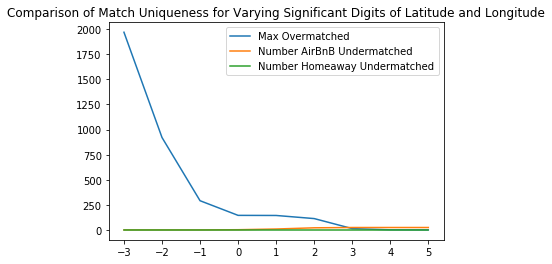

In [359]:
# Goal is to use only the property info files to find a 1-1 match for property id's
# The approach is to naively cluster and then filter based on feature similarity`
def combine_data_naive(significant_digits, vectorize_words=False):
    airbnb_property_info = pd.read_csv("property_matching_takehome/airbnb_property_info.csv")
    homeaway_property_info = pd.read_csv("property_matching_takehome/homeaway_property_info.csv")
    
#     airbnb_property_info = airbnb_property_info[["airbnb_property_id", "latitude","longitude","title","description"]]
#     homeaway_property_info = homeaway_property_info[["homeaway_property_id", "latitude","longitude","title","description"]]
        
    airbnb_property_info["latitude_x"] = airbnb_property_info["latitude"]
    airbnb_property_info["longitude_x"] = airbnb_property_info["longitude"]
    homeaway_property_info["latitude_y"] = homeaway_property_info["latitude"]
    homeaway_property_info["longitude_y"] = homeaway_property_info["longitude"]
    
    airbnb_property_info["latitude"] = airbnb_property_info["latitude"].apply(lambda x: round(x, significant_digits))
    airbnb_property_info["longitude"] = airbnb_property_info["longitude"].apply(lambda x: round(x, significant_digits))
    homeaway_property_info["latitude"] = airbnb_property_info["latitude"].apply(lambda x: round(x, significant_digits))
    homeaway_property_info["longitude"] = airbnb_property_info["longitude"].apply(lambda x: round(x, significant_digits))

    combined = airbnb_property_info.merge(homeaway_property_info,how="left",on=["latitude","longitude"])
    
    del combined["latitude"]
    del combined["longitude"]
    
    return combined

min_significant_digits = -3
max_significant_digits = 6
overmatched_list = []
left_undermatched_list = []
right_undermatched_list = []

for i in range(min_significant_digits, max_significant_digits):
    significant_digits = i

    combined = combine_data_naive(significant_digits)
    
    number_overmatched = combined["airbnb_property_id"].value_counts().max() - 1
    number_undermatched_left = len(combined[combined["homeaway_property_id"].isnull()])
    number_undermatched_right = homeaway_property_info["homeaway_property_id"].nunique() - combined["homeaway_property_id"].nunique()

    overmatched_list.append(number_overmatched)
    left_undermatched_list.append(number_undermatched_left)
    right_undermatched_list.append(number_undermatched_right)
                                                                                                    

x = [i for i in range(min_significant_digits,max_significant_digits)]

json = {}
json["Significant Digit"] = x
json["Max Overmatched"] = overmatched_list
json["Num AirBnB Undrematched"] = left_undermatched_list
json["Num Homeaway Undermatched"] = right_undermatched_list

table = pd.DataFrame.from_dict(json)
display(table)

plt.plot(x, overmatched_list, label="Max Overmatched")
plt.plot(x, left_undermatched_list, label="Number AirBnB Undermatched")
plt.plot(x, right_undermatched_list, label="Number Homeaway Undermatched")
plt.title("Comparison of Match Uniqueness for Varying Significant Digits of Latitude and Longitude")
plt.legend()
plt.show()

#Conclusion: significant digits = 0 but need to filter

In [361]:
SIGNFICANT_DIGITS = 0
naive_match = combine_data_naive(SIGNFICANT_DIGITS)
print("Number of rough matches: ", len(naive_match))
rough_matches_counts = naive_match["airbnb_property_id"].value_counts()
overmatch_ids = rough_matches_counts[rough_matches_counts > 1]
print("Number of ids that overmatched: ", len(overmatch_ids))
naive_match.dropna(subset=["homeaway_property_id"], inplace=True) #Drop if no match
naive_match.head()

Number of rough matches:  62886
Number of ids that overmatched:  1738


,id_x,airbnb_property_id,airbnb_host_id,description_x,title_x,property_type_x,neighborhood,img_cover,address,views_day,...,scraped_dt_y,updated_dt_y,premier_partner,ha_host_id,integrated_property_manager,propery_manager_profile,min_stay_default,property_theme,latitude_y,longitude_y
0,4306334,25910,96951,Casa Azul is for Adults only. Our home Casa A...,Escape From the Ordinary- Beautiful Palapa Home,House,NaN,https://a0.muscache.com/im/pictures/aaa41a30-3...,"Puerto Escondido, OAX, Mexico",NaN,...,2019-01-02 15:06:03.397110+00:00,2019-01-02 15:06:03.397110+00:00,False,NaN,True,NaN,2.0,NaN,36.578886,-93.205406
1,4397831,52834,244930,Very Important: The property is located in a r...,Luxury Riad Saad,Apartment,NaN,https://a0.muscache.com/im/pictures/305876/be2...,"Fes, Fes-Boulemane, Morocco",NaN,...,2019-01-05 20:52:56.733879+00:00,2019-01-05 20:52:56.733879+00:00,False,NaN,False,NaN,1.0,NaN,29.744209,-95.485204
2,3850509,53131,246897,We speak english / hablamos espanol / parliamo...,Central Two-Story Penthouse on 1st Avenue,Apartment,NaN,https://a0.muscache.com/im/pictures/0f004084-3...,"Playa del Carmen, Quintana Roo, Mexico",NaN,...,2019-01-02 07:40:27.706672+00:00,2019-01-02 07:40:27.706672+00:00,False,NaN,True,NaN,3.0,NaN,30.157641,-85.775982
3,3850509,53131,246897,We speak english / hablamos espanol / parliamo...,Central Two-Story Penthouse on 1st Avenue,Apartment,NaN,https://a0.muscache.com/im/pictures/0f004084-3...,"Playa del Carmen, Quintana Roo, Mexico",NaN,...,2018-12-27 01:54:17.700290+00:00,2018-12-27 01:54:17.700290+00:00,False,NaN,False,NaN,1.0,NaN,34.531120,-93.048779
4,3850509,53131,246897,We speak english / hablamos espanol / parliamo...,Central Two-Story Penthouse on 1st Avenue,Apartment,NaN,https://a0.muscache.com/im/pictures/0f004084-3...,"Playa del Carmen, Quintana Roo, Mexico",NaN,...,2019-01-02 03:16:35.496260+00:00,2019-01-02 03:16:35.496260+00:00,False,NaN,False,NaN,2.0,NaN,42.238540,3.124028


In [365]:
naive_match_enhanced = combine_and_compare_features_ml(naive_match, airbnb_property_info, homeaway_property_info, merge=False)

Calculating distance
Processing numeric features
Processing text features
title
Bag of Words Vectorizer already trained. Loading...
description
Bag of Words Vectorizer already trained. Loading...
cancellation
pets_allowed
instant_book
property_type


In [397]:
variables_to_keep = ["airbnb_property_id", "homeaway_property_id",'normalized_euclidean_distance',
 'accommodates_zscore', 'bathrooms_zscore', 'bedrooms_zscore',
 'price_nightly_zscore', 'score_zscore', 'cleaning_fee_zscore',
 'reviews_count_zscore', 'security_deposit_zscore',
 'title_cosine_similarity', 'description_cosine_similarity',
 'cancellation_agree', 'pets_allowed_agree', 'instant_book_agree',
 'property_type_agree']

feature_variables = variables_to_keep[2:]
naive_match_enhanced_filtered = naive_match_enhanced[variables_to_keep]

# Convert each metric to a distance metric rather than a similarity metric (negative is closer)
similarity_metrics = ["title_cosine_similarity", "description_cosine_similarity", "cancellation_agree", "pets_allowed_agree", "instant_book_agree","property_type_agree"]
for column in similarity_metrics:
    print(column)
    naive_match_enhanced_filtered[column] = 1 - naive_match_enhanced_filtered[column]
naive_match_enhanced_filtered.head()

title_cosine_similarity
description_cosine_similarity
cancellation_agree
pets_allowed_agree
instant_book_agree
property_type_agree


/home/daniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,airbnb_property_id,homeaway_property_id,normalized_euclidean_distance,accommodates_zscore,bathrooms_zscore,bedrooms_zscore,price_nightly_zscore,score_zscore,cleaning_fee_zscore,reviews_count_zscore,security_deposit_zscore,title_cosine_similarity,description_cosine_similarity,cancellation_agree,pets_allowed_agree,instant_book_agree,property_type_agree
0,25910,1004813vb,-0.825104,-1.123334,-0.440883,-1.297743,-0.408268,5.0,5.000000,-1.109665,5.000000,0.924055,0.976924,1,0,1,0
1,52834,1004902vb,0.428513,0.725114,0.383883,0.544310,0.019396,5.0,0.018098,-0.352330,0.510632,1.000000,0.964660,1,0,1,1
2,53131,1011345vb,-1.031864,-0.014265,0.796266,0.544310,-0.257881,5.0,5.000000,-0.081853,5.000000,1.000000,0.985579,1,0,1,1
3,53131,726134vb,-0.932345,-0.014265,1.621032,0.544310,-0.065197,5.0,-0.115900,-2.407955,5.000000,1.000000,0.952874,1,0,1,0
4,53131,8266876,0.467413,0.355425,1.621032,1.158328,-0.060498,5.0,-0.033440,0.134528,0.418968,1.000000,0.992747,1,1,1,0


In [437]:
naive_match_enhanced_filtered["prediction_simple"] = naive_match_enhanced_filtered.apply(lambda row: infer(row["normalized_euclidean_distance"], row["title_cosine_similarity"], -1, .7), axis=1)
filtered_match = naive_match_enhanced_filtered[naive_match_enhanced_filtered["prediction_simple"] == 1]

print("Filtered length match: ", len(filtered_match))
airbnb_id_value_counts = filtered_match["airbnb_property_id"].value_counts()
print("Max number airbnb overmatched: ", airbnb_id_value_counts.max() - 1)
print("Number of airbnb ids overmatched: ", sum(airbnb_id_value_counts[airbnb_id_value_counts > 1]))
print("Number of unique homeaway property ids: ", filtered_match["homeaway_property_id"].nunique())

Filtered length match:  14404
Max number airbnb overmatched:  38
Number of airbnb ids overmatched:  14049
Number of unique homeaway property ids:  342


/home/daniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


/home/daniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/daniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


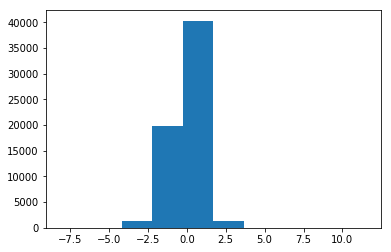

In [399]:
naive_match_enhanced_filtered["sum_distance"] = naive_match_enhanced_filtered.apply(lambda row: sum([row[column] for column in feature_variables]),axis=1)
sum_distance_mean = naive_match_enhanced_filtered["sum_distance"].mean()
sum_distance_std = naive_match_enhanced_filtered["sum_distance"].std()
naive_match_enhanced_filtered["sum_distance_normalized"]  = naive_match_enhanced_filtered["sum_distance"].apply(lambda x: (x - sum_distance_mean) / sum_distance_std)
plt.hist(naive_match_enhanced_filtered["sum_distance_normalized"])
plt.show()

In [465]:
threshold = -3.5

naive_match_enhanced_filtered["prediction"] = naive_match_enhanced_filtered["sum_distance_normalized"].apply(lambda x: 1 if x < threshold else 0)
filtered_match = naive_match_enhanced_filtered[naive_match_enhanced_filtered["prediction"] == 1]

print("Filtered length match: ", len(filtered_match))
airbnb_id_value_counts = filtered_match["airbnb_property_id"].value_counts()
print("Max number airbnb overmatched: ", airbnb_id_value_counts.max() - 1)
print("Number of airbnb ids overmatched: ", sum(airbnb_id_value_counts[airbnb_id_value_counts > 1]))
print("Number of unique homeaway property ids: ", filtered_match["homeaway_property_id"].nunique())

Filtered length match:  89
Max number airbnb overmatched:  1
Number of airbnb ids overmatched:  12
Number of unique homeaway property ids:  15


/home/daniel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [466]:
prediction_filtered = filtered_match[["airbnb_property_id", "homeaway_property_id", "prediction"]]
prediction_collapsed = prediction_filtered.groupby("airbnb_property_id").first().reset_index()

labels = pd.read_csv("property_matching_takehome/labels.csv")
matching_labels = labels.merge(prediction_collapsed, how="left", on=["airbnb_property_id", "homeaway_property_id"])
print(matching_labels["prediction"].value_counts(dropna=False))
matching_labels["prediction"].fillna(0,inplace=True)
# print(matching_labels["pre"])
print(classification_report(matching_labels["target"], matching_labels["prediction"]))

NaN    2038
Name: prediction, dtype: int64
             precision    recall  f1-score   support

        0.0       0.50      1.00      0.67      1019
        1.0       0.00      0.00      0.00      1019

avg / total       0.25      0.50      0.33      2038



/home/daniel/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Future Directions
- Add more features
- Explore different models (Gradient boosting trees, neural networks, SVM)
- Use Sum of word embeddings instead of TF-IDF
- With more data can train LSTM to build text classifier on Title/Description directly
- Use more complex clustering algorithm

Where did you set your threshold and why?
- Grid search, k-fold cross validation if necessary due to lack of data
How might you sort out the properties that fall right in the middle? 
- Add additional features, use another classifier (hierarchical post-processing), try different ML models
What fields from the original dataset might you use, and what modeling techniques could you employ.
- All of them potentially, Models: random forest, gradient boosting trees, SVM, logistic regression, etc.